In [1]:
import os
import sys
import numpy as np
import matplotlib.pyplot as plt
from matplotlib import colors
import math
from numpy import log2, zeros, mean, var, sum, loadtxt, arange, \
                  array, cumsum, dot, transpose, diagonal, floor
from numpy.linalg import inv, lstsq
import seaborn as sns
import scipy.cluster.hierarchy
from scipy.spatial.distance import squareform
import sklearn
from sklearn.decomposition import PCA
import itertools
import mdtraj as md

from PIL import Image
from IPython.display import display


This is a one millsecond trajectory of ubiquitin generated from DEShaw Research:

https://pubs.acs.org/doi/abs/10.1021/acs.jpcb.6b02024

Trajectory from DESRES can be downloaded here:
https://www.dropbox.com/s/qk4winh3y66bynm/ubq.desres.s500.zip?dl=0

It can be compared to an NMR ensmeble:
https://www.wwpdb.org/pdb?id=pdb_00002kox

In [2]:
pdb='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_3/ubq.pdb'
trajectory='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_3/ubq.desres.s500.dcd'
outdir='/Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_3/outdir'

if not os.path.exists('outdir'):
    os.makedirs('outdir')
    
print("outdir:",outdir)
print("pdb:",pdb)
print("trjaectory:",trajectory)

outdir: /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_3/outdir
pdb: /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_3/ubq.pdb
trjaectory: /Users/Vaishnavi_Home/Documents/College/Fourth Year/Spring/CHEM101/Project_3/ubq.desres.s500.dcd


In [3]:
trj = md.load(trajectory, top=pdb,stride=1)
trj.center_coordinates()
top = trj.topology
first_frame = 0
last_frame = trj.n_frames
n_frames=trj.n_frames

#hydrogen bond populations are expensive so can stride it more if too much for computer

In [4]:
#convergence depends on time scale of simulation not just about how long it is 

In [5]:
nres=[]
for res in trj.topology.residues: nres.append(res.resSeq)
sequence=([residue for residue in trj.topology.residues])
resname=( [residue.name for residue in trj.topology.residues])
resindex=([residue.index for residue in trj.topology.residues])
res_num=( [residue.resSeq  for residue in trj.topology.residues])



#log = open("/Users/paulrobustelli/Desktop/Sa_calc.log", "w")
print("** SYSTEM INFO **\n")
print("Number of atoms: %d\n" % trj.n_atoms)
print("Number of residues: %d\n" % len(set(nres)))
print("Number of frames: %d\n" % trj.n_frames)
print("Starting frame: %d\n" % first_frame)
print("Last frame: %d\n" % last_frame)
print("sequence: %s\n" % sequence)
print("residue names: %s\n" % resname)
print("residue number: %s\n" % res_num)
print("residue index: %s\n" % resindex)


** SYSTEM INFO **

Number of atoms: 1231

Number of residues: 76

Number of frames: 10088

Starting frame: 0

Last frame: 10088

sequence: [MET1, GLN2, ILE3, PHE4, VAL5, LYS6, THR7, LEU8, THR9, GLY10, LYS11, THR12, ILE13, THR14, LEU15, GLU16, VAL17, GLU18, PRO19, SER20, ASP21, THR22, ILE23, GLU24, ASN25, VAL26, LYS27, ALA28, LYS29, ILE30, GLN31, ASP32, LYS33, GLU34, GLY35, ILE36, PRO37, PRO38, ASP39, GLN40, GLN41, ARG42, LEU43, ILE44, PHE45, ALA46, GLY47, LYS48, GLN49, LEU50, GLU51, ASP52, GLY53, ARG54, THR55, LEU56, SER57, ASP58, TYR59, ASN60, ILE61, GLN62, LYS63, GLU64, SER65, THR66, LEU67, HIS68, LEU69, VAL70, LEU71, ARG72, LEU73, ARG74, GLY75, GLY76]

residue names: ['MET', 'GLN', 'ILE', 'PHE', 'VAL', 'LYS', 'THR', 'LEU', 'THR', 'GLY', 'LYS', 'THR', 'ILE', 'THR', 'LEU', 'GLU', 'VAL', 'GLU', 'PRO', 'SER', 'ASP', 'THR', 'ILE', 'GLU', 'ASN', 'VAL', 'LYS', 'ALA', 'LYS', 'ILE', 'GLN', 'ASP', 'LYS', 'GLU', 'GLY', 'ILE', 'PRO', 'PRO', 'ASP', 'GLN', 'GLN', 'ARG', 'LEU', 'ILE', 'PHE', 'ALA'

In [6]:
residue_num=[]
for res in top.residues: 
    residue_num.append(res.resSeq)
residue_id=np.asarray(residue_num)
residue_id

array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34,
       35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 51,
       52, 53, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68,
       69, 70, 71, 72, 73, 74, 75, 76])

In [7]:
#Use DSSP to calculate the secondary structure definition
#https://mdtraj.org/1.9.4/api/generated/mdtraj.compute_dssp.html
dssp=md.compute_dssp(trj,simplified=True)
dssp

array([['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ...,
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C'],
       ['C', 'E', 'E', ..., 'C', 'C', 'C']], dtype='<U2')

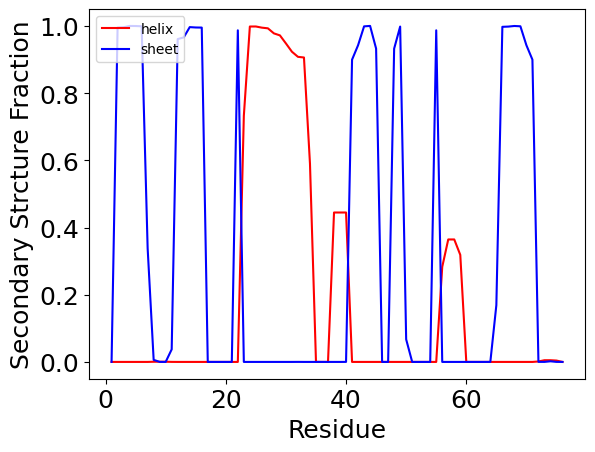

In [8]:
dssp=md.compute_dssp(trj,simplified=True)

def dssp_convert(dssp):
 dsspH=np.copy(dssp)
 dsspE=np.copy(dssp)
 dsspH[dsspH=='H']=1                                                                                      
 dsspH[dsspH=='E']=0                                                                                      
 dsspH[dsspH=='C']=0                                                                                      
 dsspH[dsspH=='NA']=0 
 dsspH=dsspH.astype(int)
 TotalH=np.sum(dsspH,axis=1) 
 Hprop=np.sum(dsspH,axis=0).astype(float)/len(dsspE) 

 dsspE[dsspE=='H']=0
 dsspE[dsspE=='E']=1
 dsspE[dsspE=='C']=0
 dsspE[dsspE=='NA']=0
 dsspE=dsspE.astype(int)
 TotalE=np.sum(dsspE,axis=1) 
 Eprop=np.sum(dsspE,axis=0).astype(float)/len(dsspE) 
 return Hprop, Eprop

Hprop,Eprop=dssp_convert(dssp)
plt.plot(residue_num,Hprop,c='r',label='helix')
plt.plot(residue_num,Eprop,c='b',label='sheet')

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


SS: H [24 25 26 27 28 29 30 31 32 33]
SS: E [ 2  3  4  5  6 12 13 14 15 16 42 43 44 45 48 49 66 67 68 69 70]
SS: I []
SS: G []
SS: B [22 55]
SS: T [19 20 46 47 52 53 60 63 64]
SS: S []
SS:   [ 1 11 17 18 35 36 37 50 51 61 62 72 76]


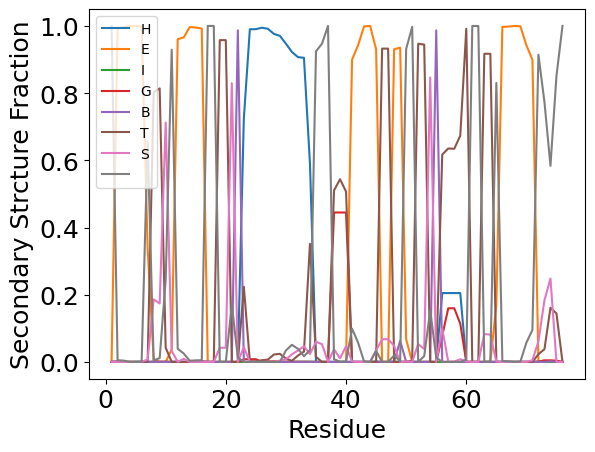

In [9]:
dssp_full=md.compute_dssp(trj,simplified=False)

def dssp_convert_type(dssp,type):
 dsspS=np.copy(dssp)
 dsspS[dsspS!=type]=0                                                                                      
 dsspS[dsspS==type]=1                                                                                      
 dsspS=dsspS.astype(int)
 TotalS=np.sum(dsspS,axis=1) 
 Sprop=np.sum(dsspS,axis=0).astype(float)/len(dsspS) 
 return Sprop

for t in ['H','E','I','G','B','T','S',' ']:
  Tprop=dssp_convert_type(dssp_full,t)
  plt.plot(residue_num,Tprop,label=t)
  print("SS:",t,np.asarray(residue_num)[np.where(Tprop>.90)])

plt.legend(loc="upper left")
plt.xlabel('Residue', size=18)
plt.ylabel('Secondary Strcture Fraction', size=18)
plt.tick_params(labelsize=18)


In [10]:
#Find all the frames where a given residue is H or E
residue_number=39
array_index=residue_number-0
print(np.asarray(residue_num)[array_index])
helix_frames=np.where(dssp[:,array_index]=='H')[0]
beta_frames=np.where(dssp[:,array_index]=='E')[0]

print("Residue %s"%np.asarray(residue_num)[array_index])
print("helix frames:",len(helix_frames),helix_frames)
print("beta frames:",len(beta_frames),beta_frames)

#a way to get frames of interest

40
Residue 40
helix frames: 4486 [    2     3     4 ... 10085 10086 10087]
beta frames: 1 [4609]


In [11]:
indices_phi, phis = md.compute_phi(trj)
indices_psi, psis = md.compute_psi(trj)
indices_chi1, chi1s = md.compute_chi1(trj)
indices_chi2, chi2s = md.compute_chi2(trj)

In [12]:
phi_dict={}
dihedral_dict = { 'phi': { },
          'psi': { },
          'chi1': { },
          'chi2': { }}

for i in range(0,len(indices_phi)):
  indices=indices_phi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['phi'][resnum]=phis[:,i]

for i in range(0,len(indices_psi)):
  indices=indices_psi[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['psi'][resnum]=psis[:,i]

for i in range(0,len(indices_chi1)):
  indices=indices_chi1[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi1'][resnum]=chi1s[:,i]

for i in range(0,len(indices_chi2)):
  indices=indices_chi2[i]
  atom=top.atom(indices[1])
  resnum=top.atom(indices[1]).residue.resSeq
  dihedral_dict['chi2'][resnum]=chi2s[:,i]

In [14]:
#Heres a function to plot a phi/psi ramachandran plot:

def plot_phipsi(res):
 plt.hist2d(dihedral_dict['phi'][res],dihedral_dict['psi'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
 plt.xlabel('$\phi$', size=18)
 plt.ylabel('$\psi$', size=18)
 plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
 plt.tick_params(labelsize=18)
 plt.show()
 return

def plot_chi(res):
    if res in dihedral_dict['chi1']:
     plt.hist(dihedral_dict['chi1'][res],bins=36,range=[-3.14,3.14])        
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('counts', size=18)
     plt.tick_params(labelsize=18)
     plt.show()
     plt.clf()   
    if res in dihedral_dict['chi2']:
     plt.hist2d(dihedral_dict['chi1'][res],dihedral_dict['chi2'][res],bins=36,range=[[-3.14,3.14],[-3.14,3.14]], norm=colors.LogNorm(),cmap='jet')
     plt.xlabel('$\chi_1$', size=18)
     plt.ylabel('$\chi_2$', size=18)
     plt.xticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.yticks([-3.14,-3.14/2,0,3.14/2,3.14],fontsize=35)
     plt.tick_params(labelsize=18)
     plt.show()
    return




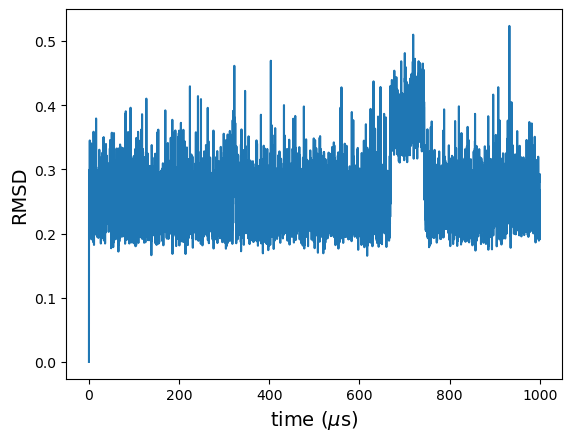

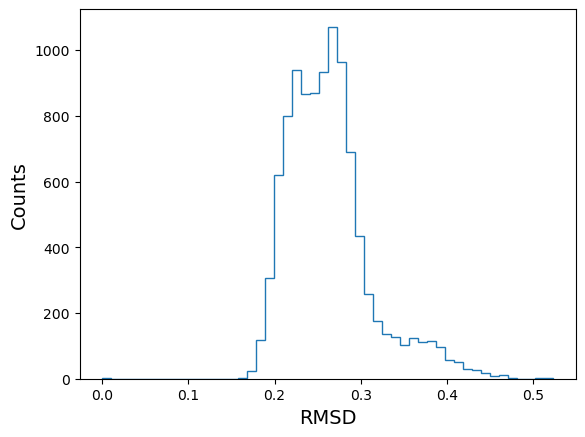

In [15]:
#Lets Calculate the RMSD and make a histogram from the starting structure 
time=np.linspace(0,1000,trj.n_frames)
rmsd = md.rmsd(trj, trj, 0)
plt.plot(time,rmsd)
plt.ylabel('RMSD',size=14);
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rmsd,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('RMSD',size=14)
plt.show()

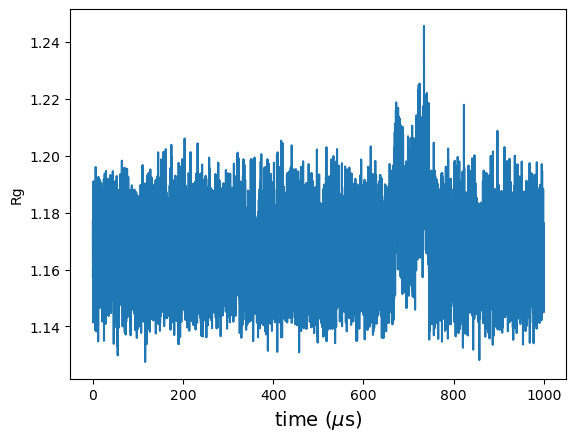

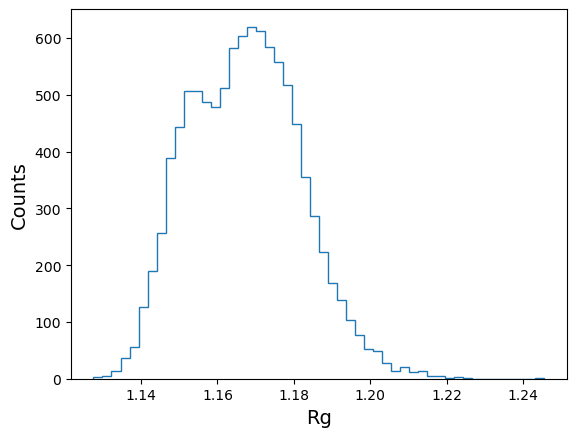

In [16]:
#Lets calculate the radius of gyration and make a histogram
rg=md.compute_rg(trj, masses=None)
#smtg about the Calphas and others not being equal or being equal or smtg

plt.plot(time,rg)
plt.ylabel('Rg');
plt.xlabel('time ($\mu$s)',size=14)
plt.show()
plt.clf()

plt.hist(rg,histtype='step',bins=50)
plt.ylabel('Counts',size=14);
plt.xlabel('Rg',size=14)
plt.show()

In [17]:
# Lets identify subtantially populated hydrogen bonds
hbonds = md.baker_hubbard(trj, periodic=False)
label = lambda hbond : '%s -- %s' % (trj.topology.atom(hbond[0]), trj.topology.atom(hbond[2]))
for hbond in hbonds:
    print(label(hbond))

#search for every H bond donor and every acceptor and show pairings, will check w trajectory to see if it meets criteria for H bond
    

MET1-N -- VAL17-O
MET1-N -- VAL17-O
MET1-N -- VAL17-O
ILE3-N -- LEU15-O
PHE4-N -- SER65-O
VAL5-N -- ILE13-O
LYS6-N -- LEU67-O
THR7-N -- LYS11-O
LEU8-N -- THR7-OG1
LEU8-N -- LEU69-O
THR9-N -- THR7-OG1
GLY10-N -- THR7-O
LYS11-N -- THR7-OG1
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
LYS11-NZ -- GLU34-OE1
LYS11-NZ -- GLU34-OE2
ILE13-N -- VAL5-O
LEU15-N -- ILE3-O
VAL17-N -- MET1-O
GLU18-N -- ASP21-OD1
GLU18-N -- ASP21-OD2
ASP21-N -- GLU18-O
THR22-N -- ASN25-OD1
ILE23-N -- ARG54-O
GLU24-N -- ASP52-O
ASN25-N -- THR22-OG1
ASN25-N -- THR22-O
ASN25-ND2 -- THR22-OG1
ASN25-ND2 -- THR22-OG1
VAL26-N -- THR22-O
VAL26-N -- ILE23-O
LYS27-N -- ILE23-O
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
LYS27-NZ -- GLN41-O
LYS27-NZ -- ASP52-OD1
LYS27-NZ -- ASP52-OD2
ALA28-N -- GLU24-O
LYS29-N -- ASN25-O
LYS29-N -- VAL26-O
ILE30-N -- VAL26-O
ILE30-N -- LYS27-O
GLN31-N -- LYS27-O
ASP32-N

In [18]:
n=0
for hbond in hbonds:
    donor = top.atom(hbond[0])
    acc = top.atom(hbond[2])
    n+=1
    print(n, hbond,donor, acc)


1 [  0   1 285] MET1-N VAL17-O
2 [  0   2 285] MET1-N VAL17-O
3 [  0   3 285] MET1-N VAL17-O
4 [ 36  37 254] ILE3-N LEU15-O
5 [  55   56 1044] PHE4-N SER65-O
6 [ 75  76 221] VAL5-N ILE13-O
7 [  91   92 1077] LYS6-N LEU67-O
8 [113 114 188] THR7-N LYS11-O
9 [127 128 119] LEU8-N THR7-OG1
10 [ 127  128 1113] LEU8-N LEU69-O
11 [146 147 119] THR9-N THR7-OG1
12 [160 161 126] GLY10-N THR7-O
13 [167 168 119] LYS11-N THR7-OG1
14 [183 184 551] LYS11-NZ GLU34-OE1
15 [183 184 552] LYS11-NZ GLU34-OE2
16 [183 185 551] LYS11-NZ GLU34-OE1
17 [183 185 552] LYS11-NZ GLU34-OE2
18 [183 186 551] LYS11-NZ GLU34-OE1
19 [183 186 552] LYS11-NZ GLU34-OE2
20 [203 204  90] ILE13-N VAL5-O
21 [236 237  54] LEU15-N ILE3-O
22 [270 271  18] VAL17-N MET1-O
23 [286 287 334] GLU18-N ASP21-OD1
24 [286 287 335] GLU18-N ASP21-OD2
25 [326 327 300] ASP21-N GLU18-O
26 [338 339 394] THR22-N ASN25-OD1
27 [352 353 869] ILE23-N ARG54-O
28 [371 372 838] GLU24-N ASP52-O
29 [386 387 344] ASN25-N THR22-OG1
30 [386 387 351] ASN25-N THR2

[  55   56 1044] PHE4-N SER65-O


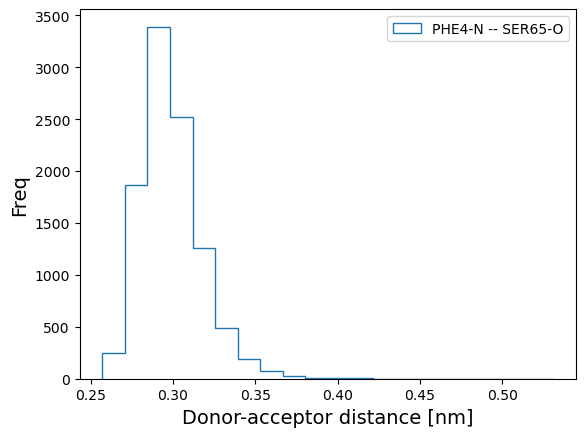

In [20]:
Hbond_index=4
hbond=hbonds[Hbond_index]
donor = top.atom(hbond[0])
acc = top.atom(hbond[2])
print(hbond,donor,acc)

da_distance = md.compute_distances(trj, [[hbond[0],hbond[2]]], periodic=False)
plt.hist(da_distance,histtype='step',bins=20, label=label(hbonds[Hbond_index]))
#for i in [2, 3, 4]:
#    plt.hist(da_distances[:, i], color=next(color),histtype='step',bins=10, label=label(hbonds[i]), alpha=0.5)
plt.legend()
plt.ylabel('Freq',size=14);
plt.xlabel('Donor-acceptor distance [nm]',size=14)
plt.show()

***We're going to run a Principle Component Analysis (PCA)***

This takes the variance of the cartesian coordinates of each atom over the course of the trajectory and finds "projections" that explain as much of variance as posisble.

https://en.wikipedia.org/wiki/Principal_component_analysis

In [21]:
import sklearn
from sklearn.decomposition import PCA

pca1 = PCA(n_components=2)
trj.superpose(trj, 0)
reduced_cartesian = pca1.fit_transform(trj.xyz.reshape(trj.n_frames, trj.n_atoms * 3))
print(reduced_cartesian.shape)

(10088, 2)


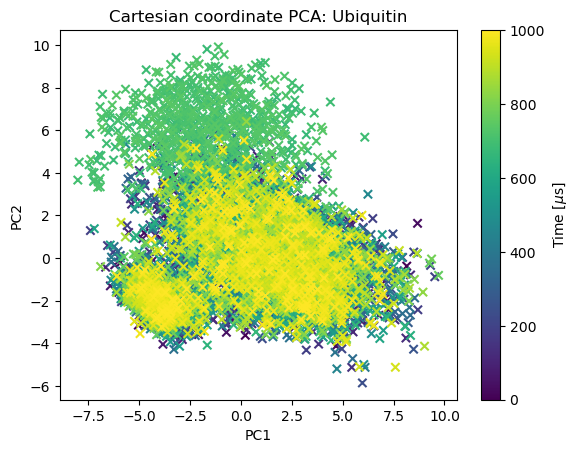

In [22]:
#We Can plot eaceh frame as a function of the values of each PC(principal component): PC1 and PC2
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=time)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('Time [$\mu$s]')

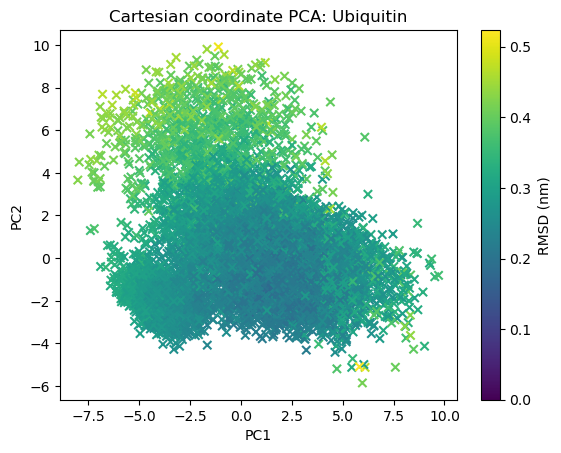

In [23]:
plt.figure()
plt.scatter(reduced_cartesian[:, 0], reduced_cartesian[:,1], marker='x', c=rmsd)
plt.xlabel('PC1')
plt.ylabel('PC2') 
plt.title('Cartesian coordinate PCA: Ubiquitin')
cbar = plt.colorbar()
cbar.set_label('RMSD (nm)')

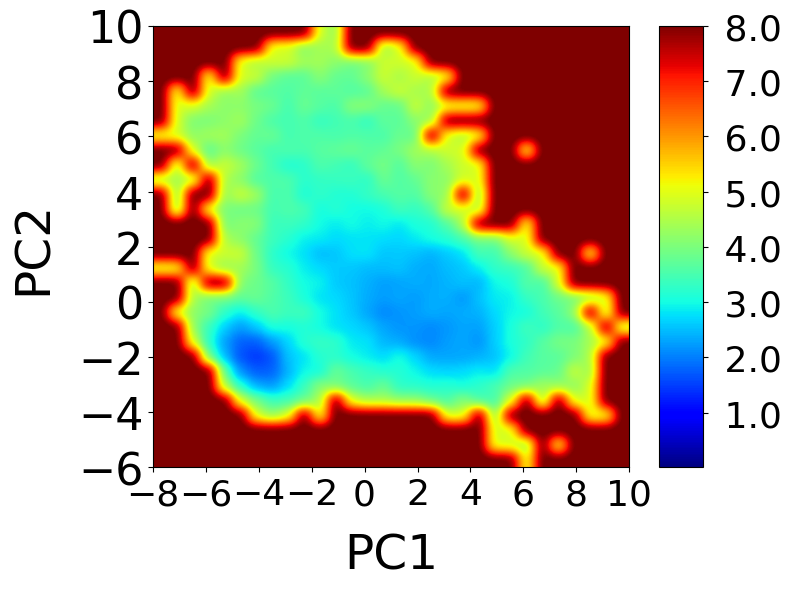

In [24]:
###Lets Make a Pretty Free Energy Plot of PC1 vs. PC2

def free_energy(a, b, T, y0, ymax, x0, xmax):
    free_energy, xedges, yedges = np.histogram2d(
        a, b, 30, [[y0, ymax], [x0, xmax]], density=True, weights=None)
    free_energy = np.log(np.flipud(free_energy)+.000001)
    free_energy = -(0.001987*T)*free_energy
    return free_energy, xedges, yedges

PC1=reduced_cartesian[:, 0]
PC2=reduced_cartesian[:,1]

dG,xedges,yedges=free_energy(PC2, PC1, 300, -6, 10, -8, 10)

fig = plt.figure(figsize=(8, 6))
im = plt.imshow(dG, interpolation='gaussian', extent=[
                yedges[0], yedges[-1], xedges[0], xedges[-1]], cmap='jet', aspect='auto')
cbar_ticks = [0, 1, 2, 3, 4, 5,6,7,8]
plt.xlim(-8,10)
cb = plt.colorbar(ticks=cbar_ticks, format=('% .1f'),
                  aspect=10)  # grab the Colorbar instance
imaxes = plt.gca()
plt.ylabel("PC2", size=35, labelpad=15)
plt.xlabel("PC1", size=35, labelpad=15)
plt.xticks(fontsize=35)
plt.yticks(fontsize=35)
plt.xticks(size='26')
plt.yticks(size='32')
plt.axes(cb.ax)
plt.clim(vmin=0.01, vmax=8.0)
plt.yticks(size='26')
plt.tight_layout()

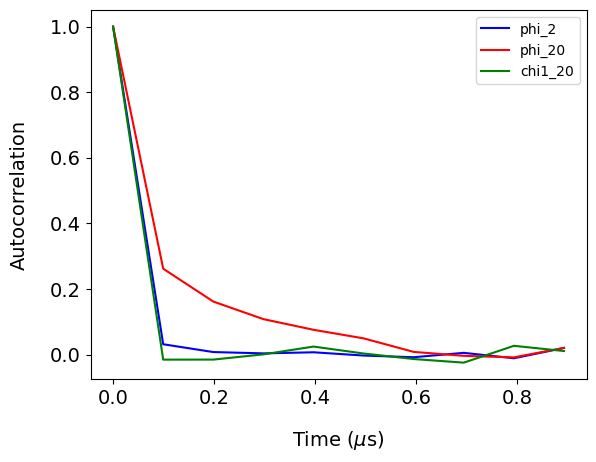

In [25]:
#Lets Calculate Some Correlation Times of Some Dihedral angles.
def autocorr1(x,lags):
    '''numpy.corrcoef, partial'''
    corr=[1. if l==0 else np.corrcoef(x[l:],x[:-l])[0][1] for l in lags]
    return np.array(corr)

#time in microseconds
time=np.linspace(0,1000,trj.n_frames)


lags=range(10)
#C1C2bondlength[:,0]
phi2_acf=autocorr1(dihedral_dict['phi'][2],lags)
phi20_acf=autocorr1(dihedral_dict['phi'][20],lags)
chi20_acf=autocorr1(dihedral_dict['chi1'][20],lags)

plt.plot(time[lags],phi2_acf,color='b',label='phi_2')
plt.plot(time[lags],phi20_acf,color='r',label='phi_20')
plt.plot(time[lags],chi20_acf,color='g',label='chi1_20')

plt.legend()
plt.xlabel("Time ($\mu$s)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

#how long it takes to lose memory of a value

In [267]:
#Lets Make a Contact Map
contact_maps = []
contact_distances = []
for i in range(1, 76):
    contact_map = []
    contact_distance = []
    for j in range(1, 76):
        if i == j:
            contacts = 0
        else:
            dist = md.compute_contacts(trj, [[i, j]])
            array = np.asarray(dist[0]).astype(float)
            distance = np.average(array)
            contact_distance.append(distance)
            contact = np.where(array < 0.5, 1, 0)
            contacts = np.average(contact)
        contact_map.append(contacts)
    contact_maps.append(contact_map)
    contact_distances.append(contact_distance)
final_map = np.asarray(contact_maps).astype(float)
final_distance = np.asarray(contact_distances).astype(float)

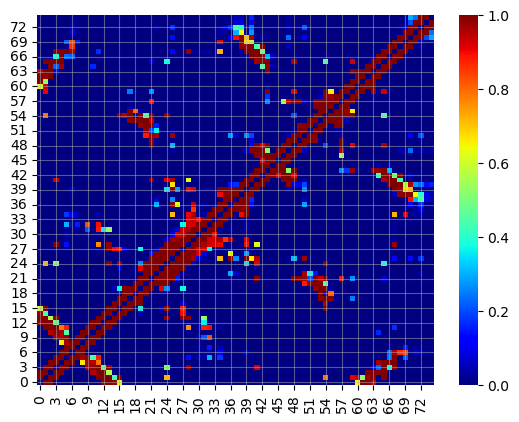

In [268]:
ax = sns.heatmap(final_map, vmin=0.0, vmax=1.0,cmap='jet')
ax.invert_yaxis()
ax.grid(which='both', alpha=0.5)


Lets think about some fun things we can do with this trajectory.  

Rubric (Completing the bolded tasks and attempting some additional tasks puts an assignment in the ~"P - B/B+" range, attempting and completing some additional more advanced tasks will earn a ~"HP - A/A-").  Very parital or incomplete attempts for the bolded questiosn is in the ~"LP / B-/C+"

Ideas:

**1.) Determine what is structural different about the "minor state" populated between 650-750us.  Can you make a visualization of the two states?** 

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

  More Advanced:
  
  2a) Can you calculate/ fit the correlation times? (fit curve function like gaussian) 
  
  2b) Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? (dictionary loop for every correlation time) 

3)Considering the minor state, can you find residues that have large changes in the distributions of backbone or sidechain dihedral angles?  Are there torsion angles with large differences in their correlation times between states?  Can you provide trajectory snapshots that explain why?

**4) Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below**  -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier. 

5) Make a 2D map showing the populations of hydrogen bonds between different residues.

6) Compare the contact maps, dihedral correlations, and hydrogen bond populations between the major and minor states.

7) Compare the contact maps, dihedral correlations, and hydrogen bond populations for different subsets of PC space (ie PC1 is on the intevral [lower1,upper1] and PC2 is on the invertval [lower2,upper2]

7) Compute an visualize all-to-all RMSD calculation of the frames of this trajectory.  

8) Cluster the conformations of the trajectory in some way.  Perhaps consider using the all-to-all rmsd distances, or the the values of PCs.  (Consult https://mdtraj.org/1.9.4/examples/clustering.html or https://mdtraj.org/1.9.4/examples/centroids.html for examples)


9) Visualize the most populated clusters from your clustering analysis

Here is the equation used to calculate circular correlation coefficients for dihedral angles

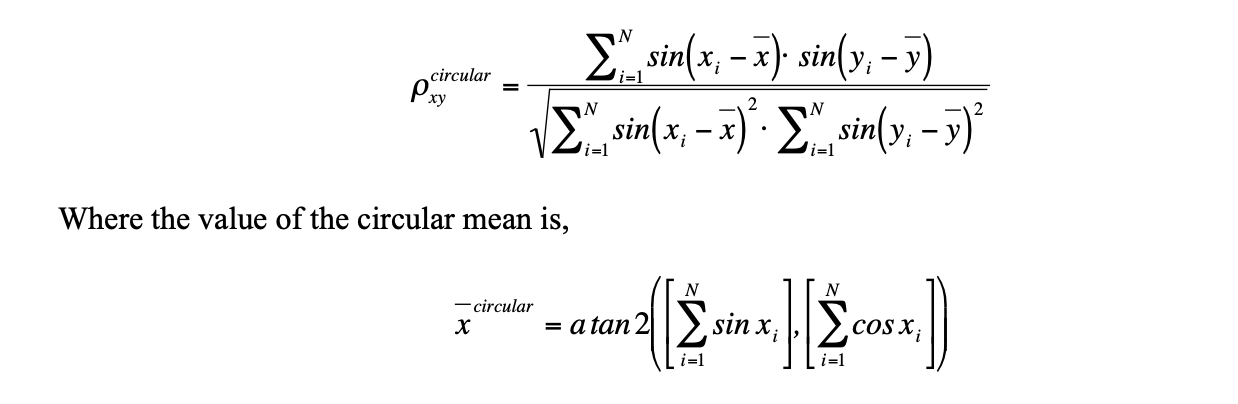


Lets calculate some correlations between dihedrals found in the paper: 


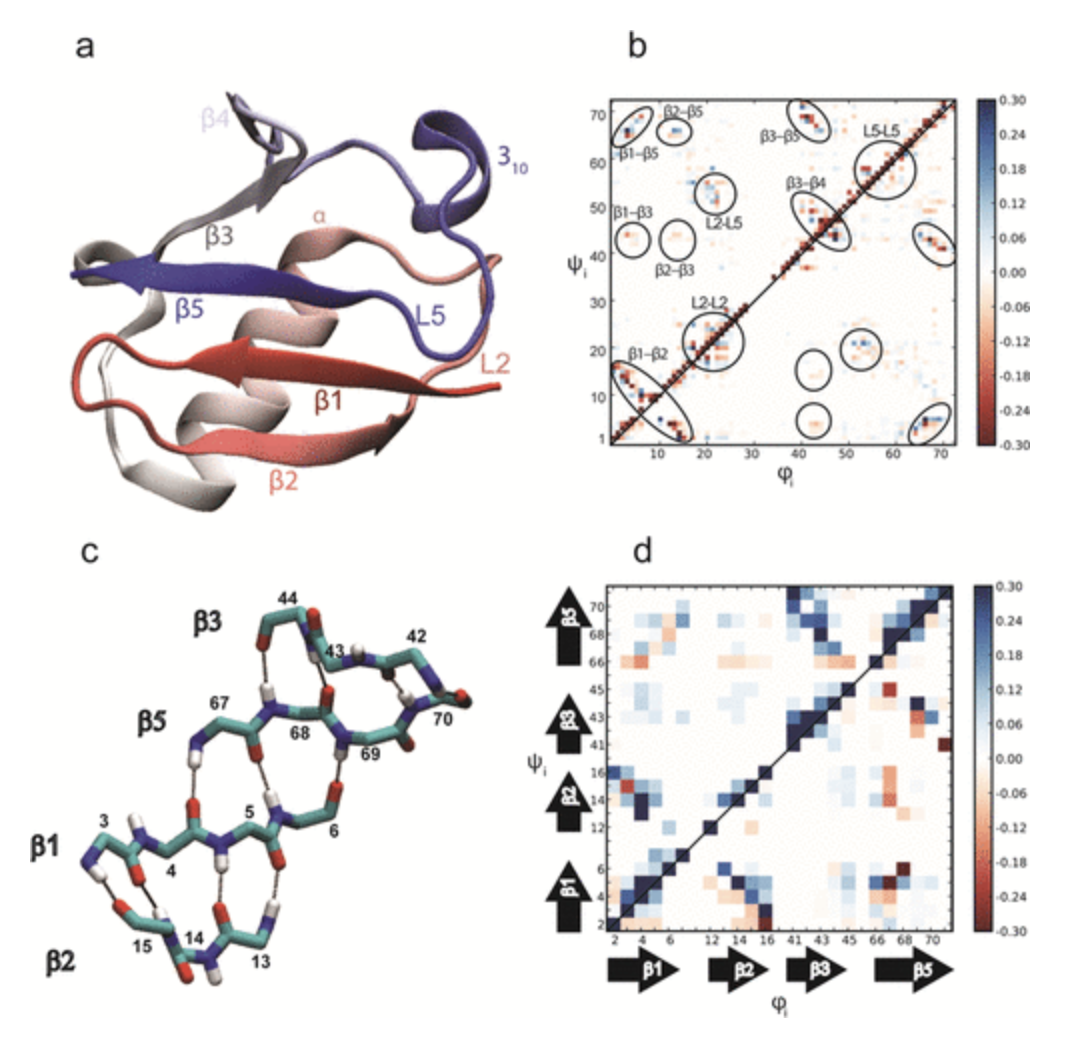

## Problem 1: Minor state in 650-750 us

Based on the plots above, we can see that the main structural difference is the radius of gyration. For the majority of the trajectory, the protein has a Rg of 1.17 whereas at 650-750 us, it has a value of 1.21 (more open/less compact state). We can visualize this in VMD. 
If there are 10,088 frames in the simulation and it lasts 1 ms, frames at 6557-7566 should include the minor state. Let's look at frame 0 vs frame 6815. 

The difference between these two frames is very clear. One helix opens up in the minor state, causing the more extended radius of gyration, as seen below.

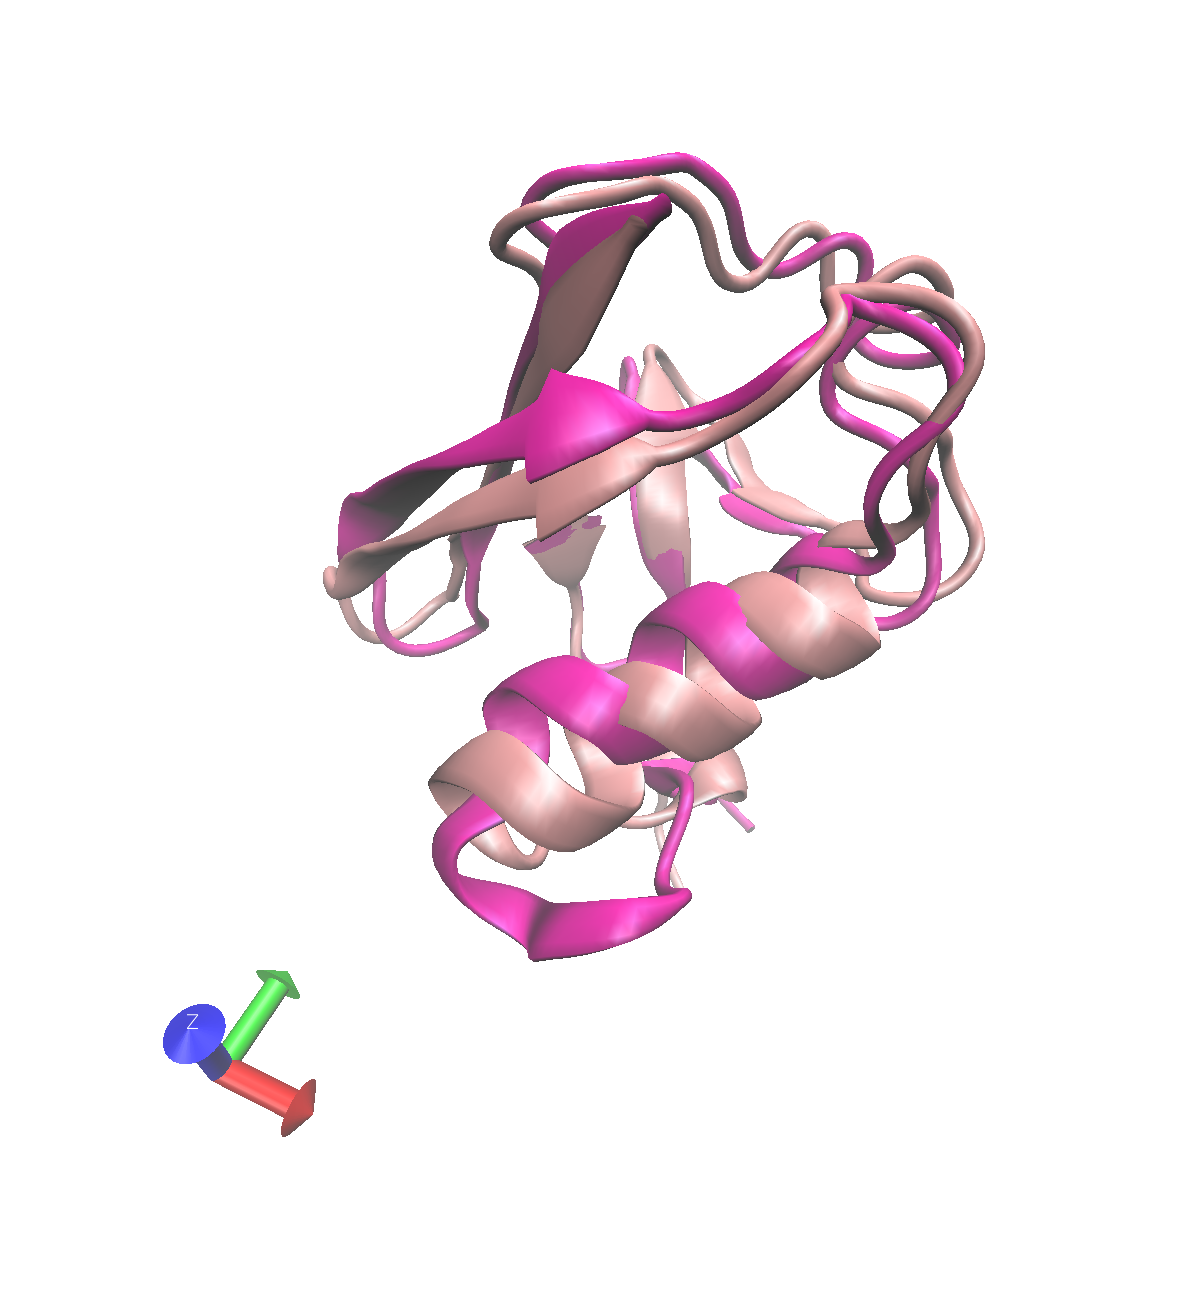

In [26]:
image_path = outdir + "/q1.png"

img = Image.open(image_path)
display(img)

In this image, the light pink structure is ubq at frame 0, and the dark pink is frame 6815 (~675us). As we can see, the last turn of the helix is open in the minor state. We can look at how this changes specific residue interactions below. 

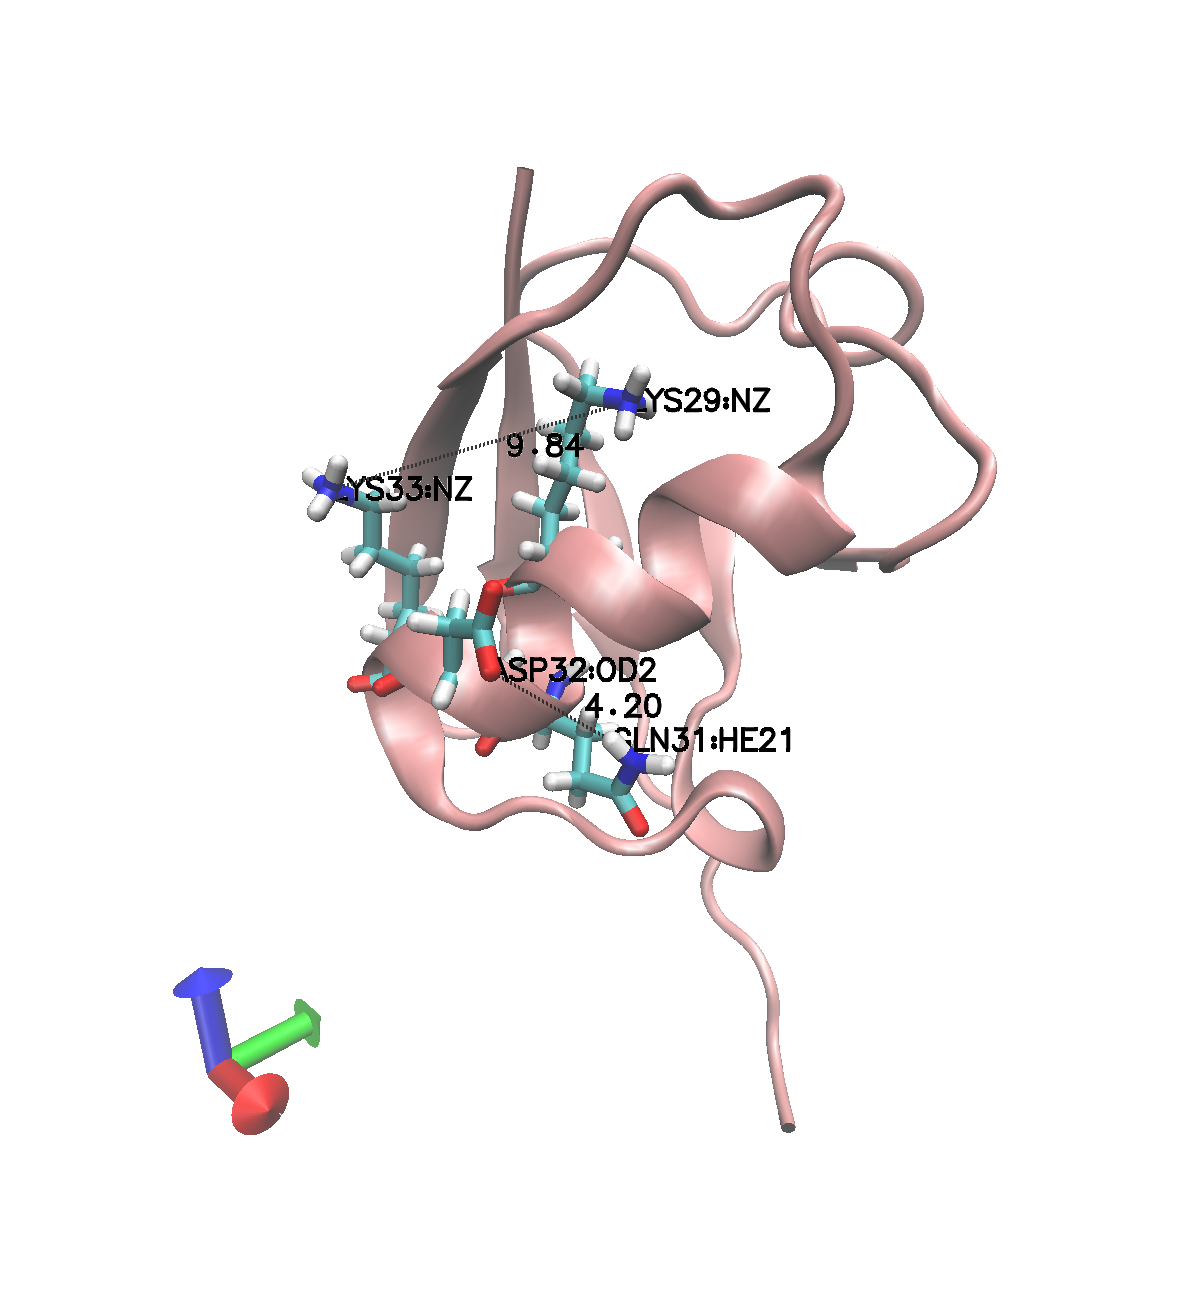

In [27]:
image_path = outdir + "/q1_frame0.png"

img = Image.open(image_path)
display(img)

In this frame (frame 0) I've picked out two interactions that change dramatically between the more populated/minor state:
1. The + + unfavorable interaction between two positively charged lysine groups (with a distance of 9.84)
2. The stabilizing hydrogen bond between GLN31 and ASP32 with a distance of 4.20.

*Note that both of these interactions are not quite close enough to cause tight bonds (for example, hydrogen bonding requires distances of less than about 3.5A). However, the interactions change noticeably which is why I've decided to include them and the long-range interactions likely still play a role in the protein dynamics. 

As this turn of the helix breaks, these interactions change dramatically. 

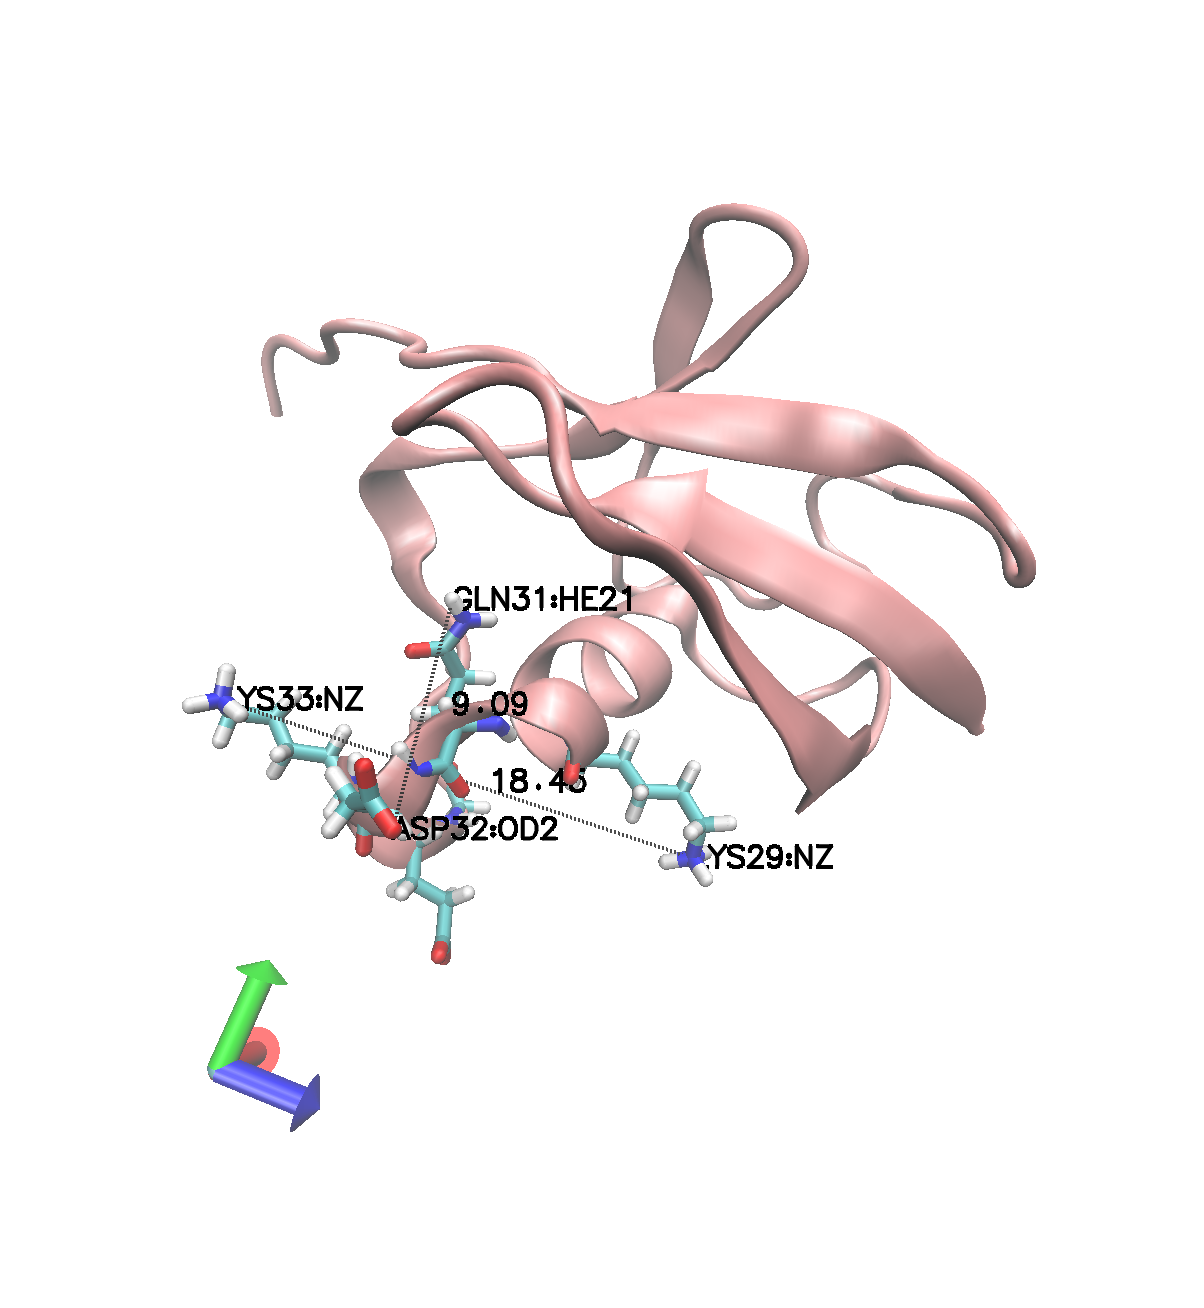

In [28]:
image_path = outdir + "/q1_frame6815.png"

img = Image.open(image_path)
display(img)

Here, the ++ distance between the two lysine residues is much farther, and the hydrogen bond is roughly doubled distance between the residues. All of the residues on the turn of helix that becomes more outstretched are turned entirely away from the rest of the helix. 

We can also look to see how the distribution of secondary structure changes between the minor state and the more populated state.

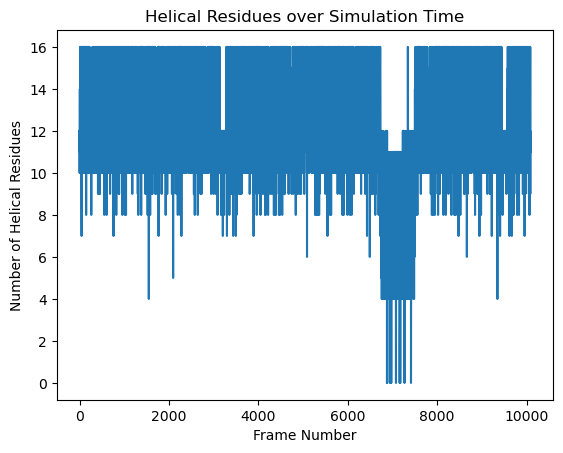

In [29]:
# Can look at number of helical frames over time of the simulation too 

H_frames = np.sum(dssp_full == 'H', axis=1)
H_array = H_frames.reshape(-1, 1)

frames = np.array(np.arange(1, 10089, 1))
frames = frames.reshape(-1, 1)

plt.plot(frames, H_array)
plt.xlabel('Frame Number')
plt.ylabel('Number of Helical Residues')
plt.title('Helical Residues over Simulation Time')
plt.show()


We can clearly see a significant drop in helical residues at 650-750 us, which coresponds to the VMD visualizations outlined above!

## Problem 2: Looking at correlation times

**2.)  Identify some dihedral angles that have very long correlation times? Can you your provide structural snapshots that explain why certain correlation times are longer?**

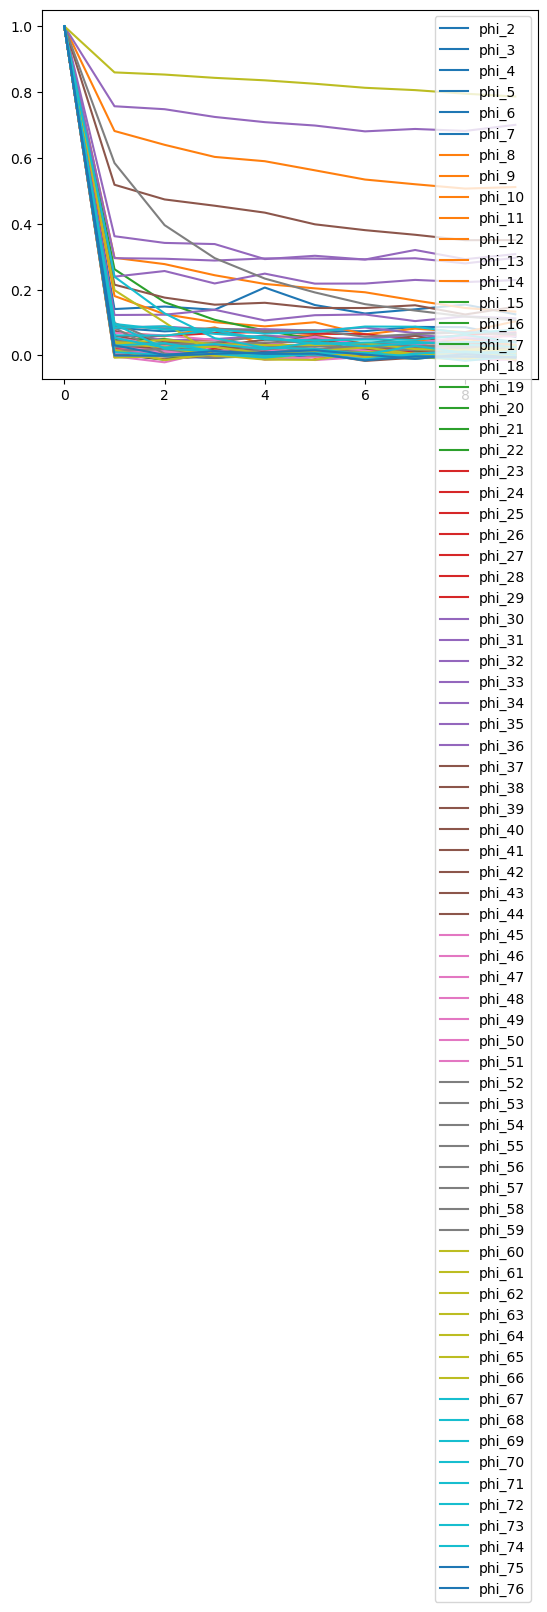

In [30]:
#just to get a rough idea of which phi angles have a long correlation time/are correlated together

colors = plt.cm.tab10(np.linspace(0, 1, len(dihedral_dict['phi'])))

# Plot each line with a unique color
for i in dihedral_dict['phi']:
    acf = autocorr1(dihedral_dict['phi'][i], lags)
    plt.plot((lags), acf, color=colors[i % len(colors)], label=f'phi_{i}')   # Unique label for each line

# Add legend
plt.legend()

# Show plot
plt.show()


While this is a super rough image, we can see that the two purple lines with an ACF of about 0.35 over time have a phi angle that's correlated. And since both of these residues are near each other, they likely interact and influence some of this behavior. Purple lines are index 30 to 36. 

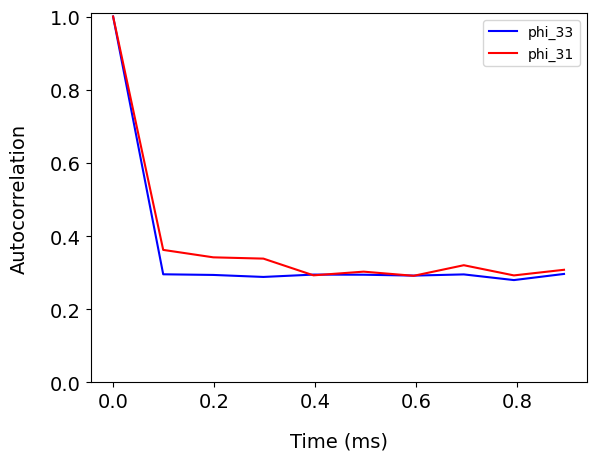

In [34]:
#Borrowing the function defined above
time=np.linspace(0,1000,trj.n_frames)
lags=range(10)

#C1C2bondlength[:,0]
phi33_acf=autocorr1(dihedral_dict['phi'][33],lags)
phi31_acf=autocorr1(dihedral_dict['phi'][31],lags)

plt.plot(time[lags],phi33_acf,color='b',label='phi_33')
plt.plot(time[lags],phi31_acf,color='r',label='phi_31')


plt.legend()
plt.xlabel("Time (ms)", size=14, labelpad=15)
plt.ylabel("Autocorrelation", size=14, labelpad=15)
plt.ylim(0,1.01)
plt.xticks(fontsize=14)
plt.yticks(fontsize=14)
plt.xticks(size='14')
plt.yticks(size='14')
plt.show()

Index 33 and 31 in the phi dictionary have super long phi angle ACFs that match! Which means residue ASP32 and LYS33 have a phi angle that remains stable and GLU34 and GLY35 are pretty correlated. Both of these pairs are likely correlated with each other given their proximity. Let's look at what LYS33 and GLY35 look like over time.

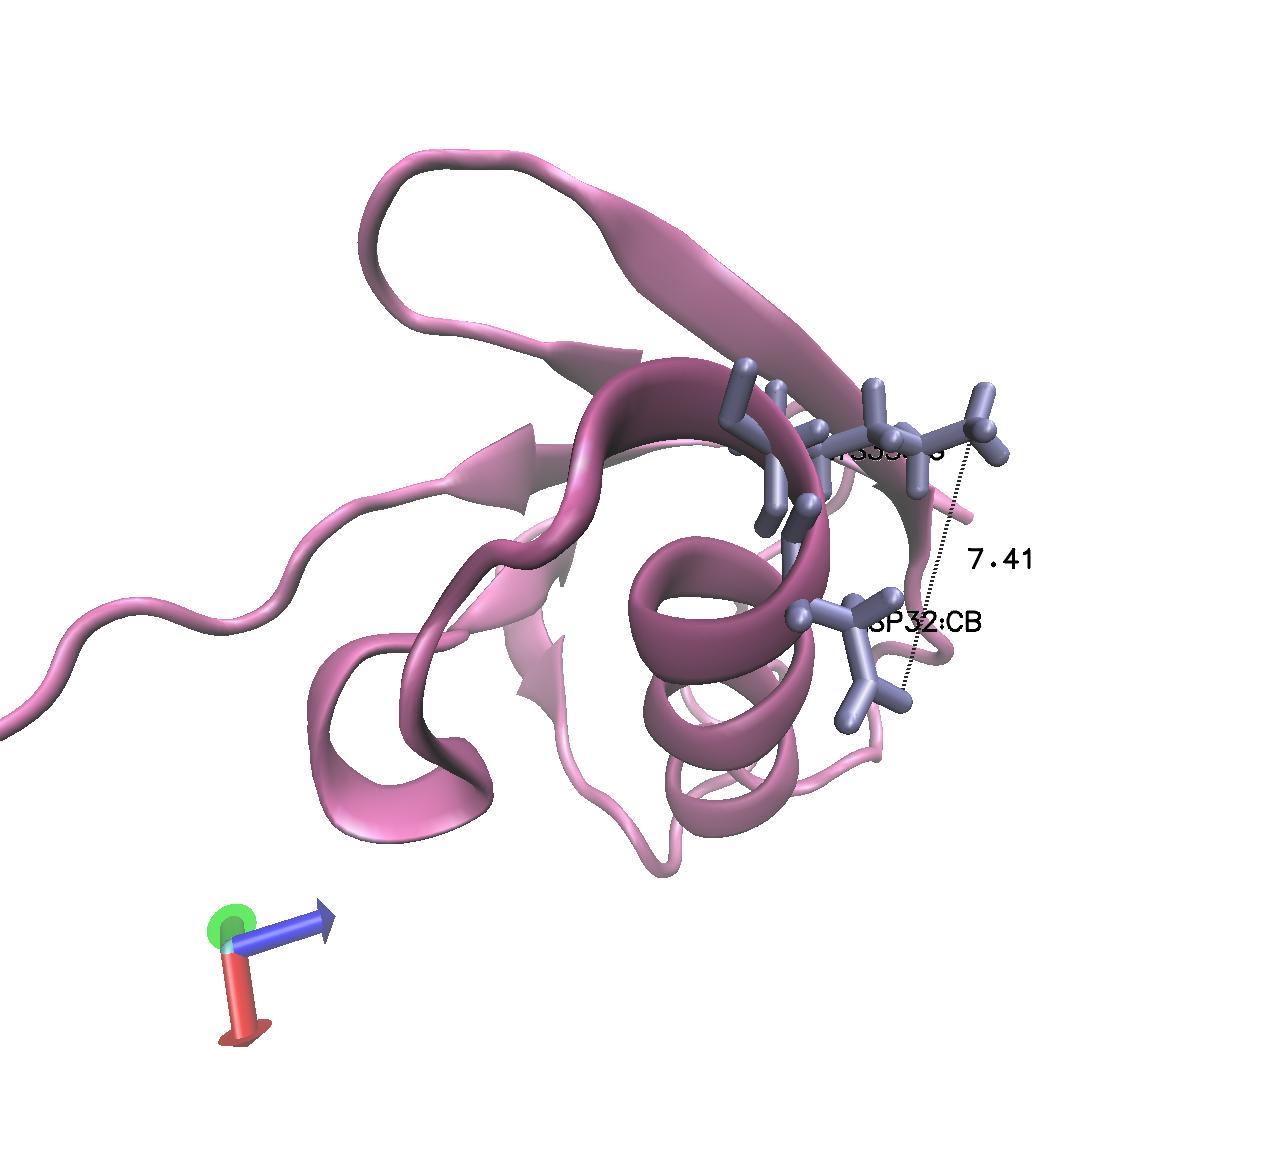

In [35]:
#res 32 and 33 at frame0
image_path = outdir + "/acf33_frame0.png"
img = Image.open(image_path)
display(img)

This image is at frame 0 where the helix is still intact. Let's see what the angle looks like at frame 6815 (helix opens up). 

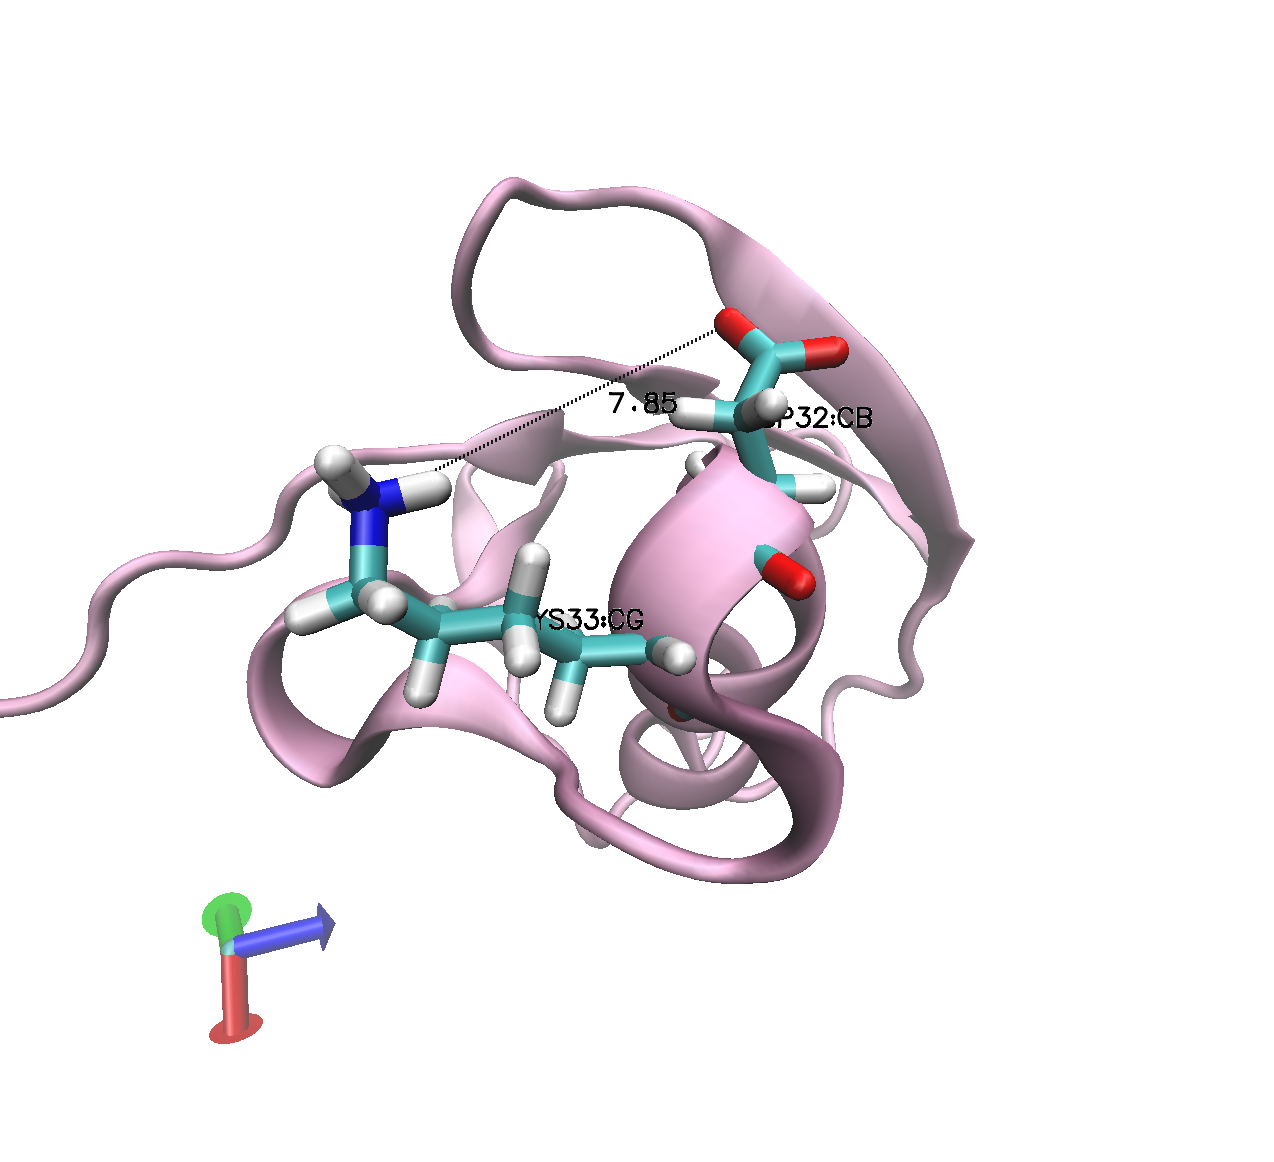

In [36]:
#res 32 and 33 at frame0
image_path = outdir + "/acf33_frame6815.png"
img = Image.open(image_path)
display(img)

Looking at the frame where the helix is more open, we can see that the bond angle still looks the same! This image is rotated so we can compare the angle, with the residues themselves positioned in roughly the same spot between both frames. 

This correlation is also interesting to consider since it's between ASP and LYS, two amino acids with opposite charges at neutral pH. Given that there is a salt bridge interaction here, it makes sense that the residues are correlated as the interaction helps stabilize the protein. While the distance between the positively charged NH2 and negative O are not super close (7.85), it's cool to see the distance remains pretty similar across frames and across pretty different structures. 

We can similarly compare residues 59 and 60. Let's look at those overlaid.

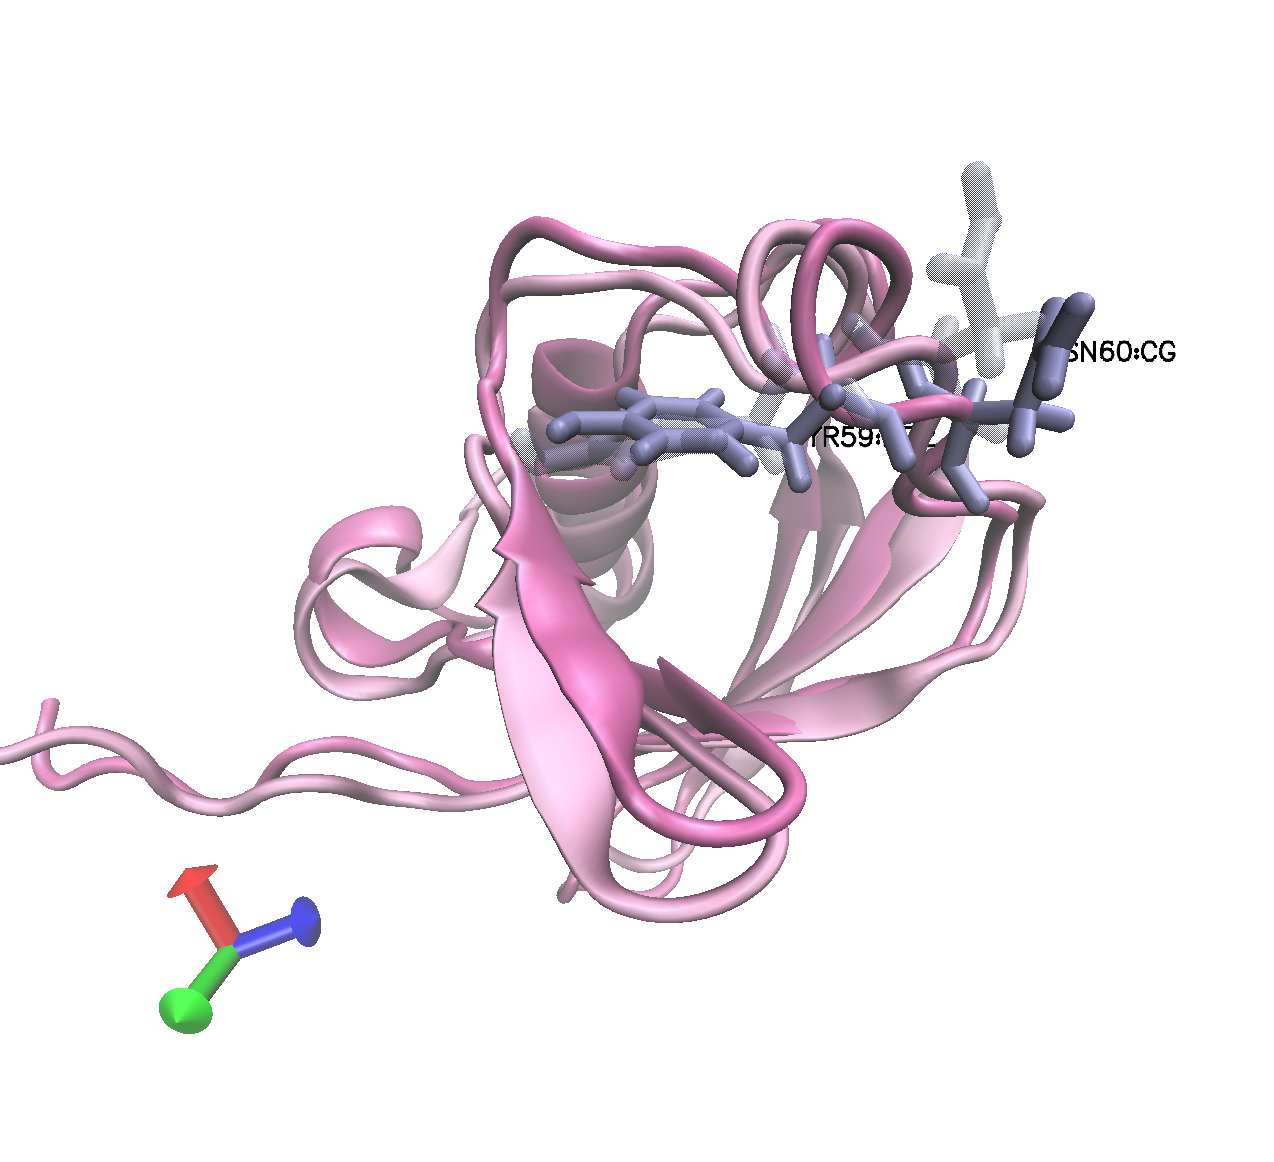

In [37]:
#res 59 and 60 
image_path = outdir + "/acf_60.png"
img = Image.open(image_path)
display(img)

In this image, the opaque structures are at frame 0 with the transparent residues/brushed metal representation is at 6815. This correlation is easier to see since the resiudes are not on the helix that pops out. As this turn remains relatively stable over the trajectory, it makes sense that residues (especially bulky ones that have steric restrictions) have a high autocorrelation (since there are likely only a few ways to get these residues to "fit"). 

## Problem 4: Circular correlation coefficients

Calculate the ciruclar correlation coefficients between phi and psi angles and reproduce the correlation map from below -Look into using a "mask" to eliminate some entries in the correlation matrix and make your plot prettier.

In [38]:
#first defining functions based on the equations given
def circular_mean(angle):
    mean = np.arctan2(np.sum(np.sin(angle)),np.sum(np.cos(angle)))
    return mean 

def circular_corr(angle1,angle2):
    circ_mean1=circular_mean(angle1)
    circ_mean2=circular_mean(angle2)
    
    num=(np.sum(np.sin(angle1-circ_mean1)*np.sin(angle2-circ_mean2)))
    denom=((np.sum(np.sin(angle1-circ_mean1)**2)*np.sum(np.sin(angle2-circ_mean2)**2))**.5)
    
    corr = num/denom
    return corr

In [40]:
#now finding the values for all of the phi/psi angles

correlation =[]

#N term no phi, C term no psi angle, so just look at the correlations between the angles from res 2 to 75 out of the 76 total amino acids
#calculate between each residue pair (ex start with res 2, find values between res 2 and for res 2-75). Then move on to res 3 and repeat. 

for i in range(2, 75):
    res_corr = []
    
    for j in range(2, 75):
        phi=dihedral_dict['phi'][i]
        psi=dihedral_dict['psi'][j]
        
        circ_corr=circular_corr(psi,phi)
        res_corr.append(circ_corr) 
        
    correlation.append(res_corr) 


total_correlation_map = np.asarray(correlation).astype(float)

In [41]:
#to check we have every pair AND every i-j pair within each residue
print(len(total_correlation_map))
print(len(total_correlation_map[1]))

73
73


A square matrix - what we needed! Diagonal should also have the highest values (since these are comparing the same residues to each other). 

Text(50.722222222222214, 0.5, 'Residue')

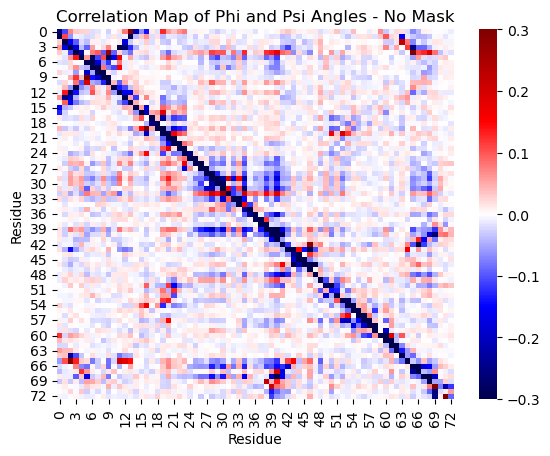

In [42]:
#can use seaborn package to make a heatmap of square matrix correlation data 
sns.heatmap(total_correlation_map, vmin=-0.3, vmax=0.3, cmap='seismic')
plt.title("Correlation Map of Phi and Psi Angles - No Mask")
plt.xlabel("Residue")
plt.ylabel("Residue")

Adding a mask since there's so much going on! Let's eliminate entries centered around 0 since those aren't as interesting

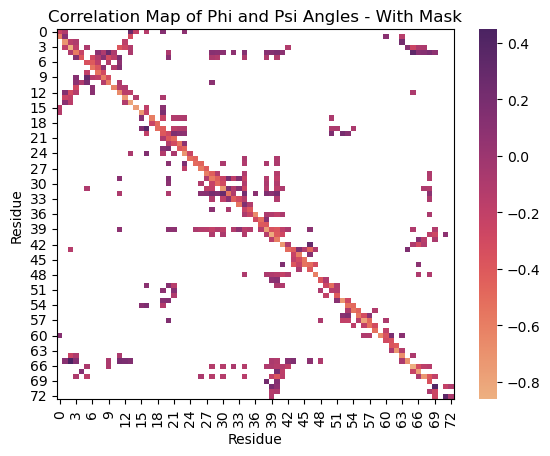

In [43]:

mask = np.logical_and(total_correlation_map >= -0.08, total_correlation_map <= 0.08)

sns.heatmap(total_correlation_map, mask=mask, cmap='flare')
#also using a pretty package 

#also adding a border bc that's easier to see 
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)


plt.title("Correlation Map of Phi and Psi Angles - With Mask")
plt.xlabel("Residue")
plt.ylabel("Residue")

# Show the plot
plt.show()


Much easier to see! 

# **Some advanced prompts!**

## H bond 2D Map

I think heat maps are pretty so will make one of H bonds! 

What we need to do to make this happen:
- find the distance between all of the pairs of H bonds in the "hbonds" array
- figure out the population of frames in that hbond
- plot a 2D map that shows the populations in varying intensities (note: majority of entries in this will have NO h bonds because we only care about the interactions that are close enough to be an h bond and are thus in the hbonds array calculated above)

Going to work through this with a series of loops then plot the data to make a new dictionary that can keep track of bonds/populations. 

In [46]:
# Storing populations in a dictionary 
hbonds_pop = {}

# Add info from hbond populations to this dictionary 
for hbond in hbonds:
    donor_res = top.atom(hbond[0]).residue.index
    acceptor_res = top.atom(hbond[2]).residue.index
    # using scaffold of code from above, we know that donors and acceptors are these corresponding indices in hbonds
    
    # Since we don't have an actual h bond for every single pair, we are going to use an if statement to make sure that we can organize 
        #the dictionary in a way that makes it easier to plot (ie ascending order)  
    if donor_res > acceptor_res:
        donor_res, acceptor_res = acceptor_res, donor_res
    
    pair = (donor_res, acceptor_res)

    # set up the pairs in the dictionary and make sure it doesn't repeat 
    if pair not in hbonds_pop:
        hbonds_pop[pair] = 0
    
    # Calculate bond 
    bond_distance = md.compute_distances(trj, [[hbond[0], hbond[2]]], periodic=False)
    # this is going to give us a bond distance for every single frame. we really only care about the frames where the h bond is intact
    # so, let's only sum the relevant frames and add that to the dictionary to get number of frames above threshold 

    frame_nums = 0
    #Try to find number of frames that have an h bond
    for i in bond_distance:
        if i < 0.35:
            frame_nums += 1 
        hbonds_pop[pair] = frame_nums
    # this part is basically adding up all the frames that have a distance close enough to be an h bond 
    # then we store that in hbonds_pop to get all the info in one spot 

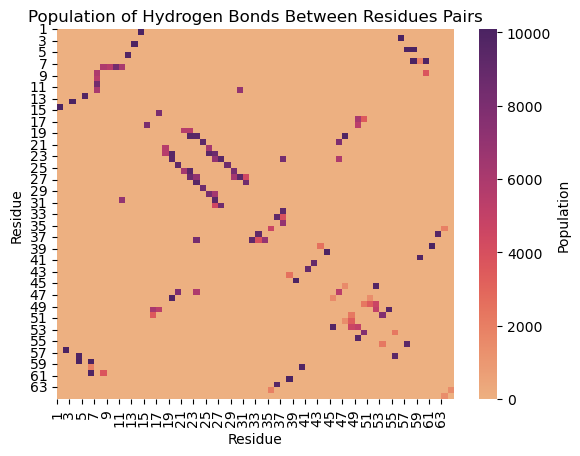

In [47]:
#now that we have all the info, let's make it into something we can plot as a 2D plot 

residues = sorted(set([res for pair in hbonds_pop.keys() for res in pair]))
#Going to iterate over every pair of h bonds (which are the keys in the dictionary) and 
    #then over each of the two residues in that pair to make one list of residues that are 
    #involved in  bonding. From there, we'll remove duplicates with "set" and then sort the list again to make the data clean.


# Make the dictionary into a square array for plotting by residue 
hbonds_array = np.zeros((len(residues), len(residues)))

# Fill the array with hydrogen bond populations
# iterating over every h bond pair and storing the res donor, acceptor, and count into the matrix 
for (donor_res, acceptor_res), count in hbonds_pop.items():
    i = residues.index(donor_res)
    j = residues.index(acceptor_res)
    hbonds_array[i, j] = count
    hbonds_array[j,i]= count
    #making it square to get the necessary plot 


# Plot the heatmap
sns.heatmap(hbonds_array, xticklabels=residues, yticklabels=residues, cmap='flare', cbar_kws={'label': 'Population'})
plt.xlabel('Residue')
plt.ylabel('Residue')

#so its easier to see just gonna mark every other res on the axis 
plt.xticks(range(0, len(residues), 2), [str(res) for res in range(1, len(residues)+1, 2)])
plt.yticks(range(0, len(residues), 2), [str(res) for res in range(1, len(residues)+1, 2)])


plt.title('Population of Hydrogen Bonds Between Residues Pairs')
plt.show()


As expected, we only see a select few entries that actually have h bonds! A nice plot. Going to add a mask so it's easier to see the interesting residues. 

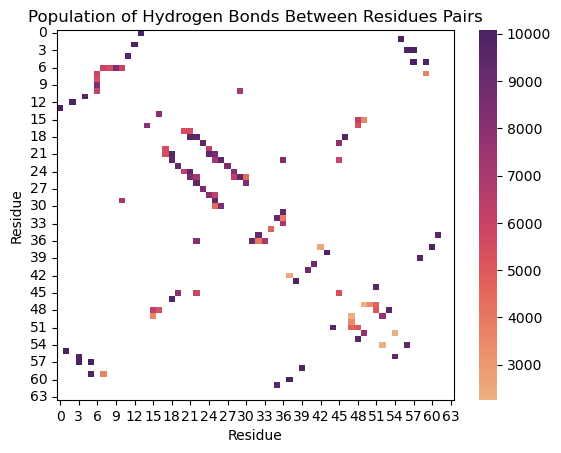

In [48]:
mask = hbonds_array <2000

sns.heatmap(hbonds_array, mask=mask, cmap='flare')

#also adding a border bc that's easier to see 
plt.gca().spines['top'].set_visible(True)
plt.gca().spines['right'].set_visible(True)
plt.gca().spines['bottom'].set_visible(True)
plt.gca().spines['left'].set_visible(True)

plt.xlabel('Residue')
plt.ylabel('Residue')
plt.title('Population of Hydrogen Bonds Between Residues Pairs')

# Show the plot
plt.show()



## Loop through dihedrals and autocorrelation times

Can you write a loop to scan over all phi/psi/chi1/chi2 residues and identify residues with correlation times longer than a given threshold? (dictionary loop for every correlation time)

To make this happen:
- should calculate the correlation for every residue/dihedral
- should figure out if the correlation is above the threshold
- store that info in a dictionary that separates out the phi/psi/chi1/chi2 info 

In [50]:
acf_thresh = 0.5 #the level of correlation we want
time_thresh = 0.45 #time after which a correlation is considered interesting to us

dihedral_corr = {} 
time = 1 #total time of lags we're looking at 
points = 10 #how many lags within this time do we want to calculate?

#finding the index that corresponds to where our time threshold is 
threshold_comparison = int(((time_thresh/time)*points)-1)
# find fraction of time that is below the threshold * points in the data set and then subtract 1 to account for 0 index 


angles = ['phi', 'psi', 'chi1', 'chi2']

for angle in angles: 
    dihedral_corr[angle] = []
    #making array for diciontary 
    
    # Going through each different residue and calculating autocorrleation
    for res in range(77): 

        #some residues are missing certain dihedrals bc of physical reasons (ex c terminus doesnt have psi angle) 
        if res in dihedral_dict[angle].keys():
            
            acf = autocorr1(dihedral_dict[angle][res], range(points))
            #gives array with length dependening on the number of points 
            #finding the index in this array that correspond to the time of interest above 

            #figure out which ones have a value above the threshold of interest at the time of interest 
            if acf[threshold_comparison] > acf_thresh: 
                dihedral_corr[angle].append(res)
                #compares the acf value at the index at the time of interest and compares to the acf threshold we set above 

print(dihedral_corr)

{'phi': [10, 35, 60], 'psi': [9, 13, 30, 31, 32, 33, 34, 51, 59], 'chi1': [], 'chi2': [59]}


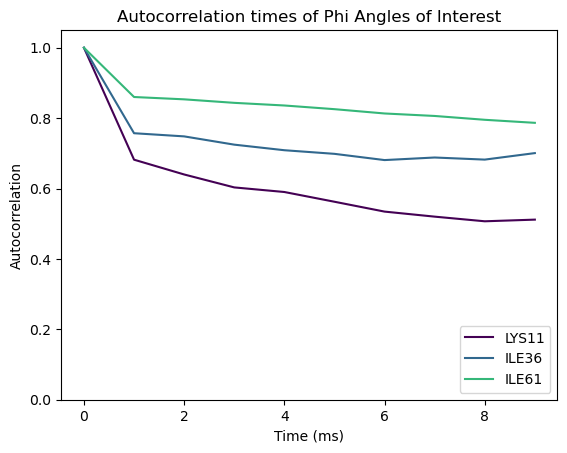

In [51]:
res_total = len(dihedral_corr['phi'])  # Total number of residues

#let's also use a nice color map and cycle through 
cmap = plt.cm.viridis

for index, res in enumerate(dihedral_corr['phi']): 
    acf = autocorr1(dihedral_dict['phi'][res], range(points))
    color_frac = index / res_total  
    color = cmap(color_frac)  
    plt.plot(range(points), acf, label=sequence[res], color=color)


plt.legend(loc="lower right")
plt.ylabel('Autocorrelation')
plt.xlabel('Time (ms)')
plt.ylim(0,1.05)
plt.title("Autocorrelation times of Phi Angles of Interest")
plt.show()


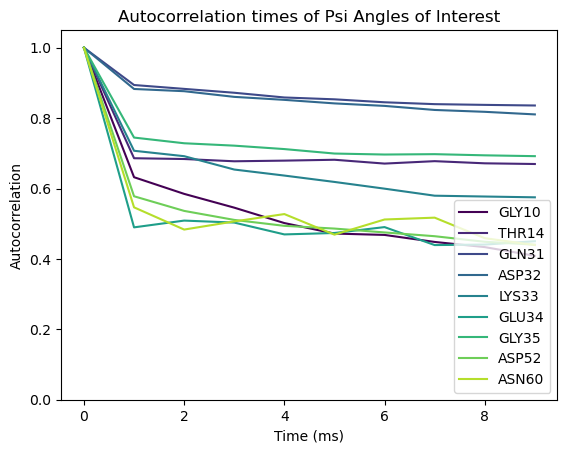

In [52]:
#Psi Angles 
res_total = len(dihedral_corr['psi'])  
cmap = plt.cm.viridis

for index, res in enumerate(dihedral_corr['psi']): 
    acf = autocorr1(dihedral_dict['psi'][res], range(points))
    color_frac = index / res_total  
    color = cmap(color_frac)  
    plt.plot(range(points), acf, label=sequence[res], color=color)


plt.legend(loc="lower right")
plt.ylabel('Autocorrelation')
plt.xlabel('Time (ms)')
plt.ylim(0,1.05)
plt.title("Autocorrelation times of Psi Angles of Interest")
plt.show()
